In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_theme()
# %matplotlib notebook

# Read the Graph

In [2]:
G = nx.read_edgelist('h3_graph_data.edgelist')

# Functions

### SIR function

In [3]:
def SIR(G, p, t0_infect_set, T=None):
    """
    SIR simulation, return the `Total_InfectedNodes`

    INPUT:
    - ``G`` -- NetworkX graph object
    - ``p`` -- transmission probability
    - ``t0_infect_set`` -- specific nodes of infection at t=0
    - ``T`` -- MaxIterations, default = nodes number of Graph
    OUTPUT:
    - ``len(R)`` -- Total_InfectedNodes
    """
    # MaxIterations, default = nodes number of Graph
    if T is None:
        T = G.number_of_nodes()
    
    # Iteration number 
    t=0
    
    # 3 sets for S,I,R
    R = set()
    I = set(t0_infect_set)
    S = set(G.nodes())-I
    
    # End judgment
    while t<T and len(I)!=0:
        t+=1
        # Update R set
        R = R|I
        infect_neighbor = set()
        new_infect = set()
        
        for infect_node in I:
            for node in G.neighbors(infect_node):
                # Probablity p to set a node as infected
                if node not in R and np.random.binomial(1, p):
                    new_infect.add(node)
        # Update S,I set
        S = S - new_infect
        I = new_infect

    return (len(R))

### Greedy algorithm

In [4]:
def find_best_partner(G, p, nodeset_left, nodeset_right,r=5):
    """
    Return the best_partner for fixed ``nodeset_left`` from candidate set``nodeset_right``,
    which can lead to the maximum possible expected spread.

    INPUT:
    - ``G`` -- NetworkX graph object
    - ``p`` -- transmission probability
    - ``nodeset_left`` -- fixed given set
    - ``nodeset_right`` -- candidates set
    - ``r`` -- run``r``times simulations of SIR, use the average spread as `f(S)`
    OUTPUT:
    - ``best_partner`` -- a node, the best partner
    """
    
    each_nodeset_infect = dict()
    for node in nodeset_right:
        nodeset_left.append(node)
        
        five_times_record = list()
        for m in range(r):
            five_times_record.append(SIR(G, p, nodeset_left))
        each_nodeset_infect[node] = np.average(five_times_record)
        
        nodeset_left.remove(node)
    best_partner = max(each_nodeset_infect, key=each_nodeset_infect.get)
    
    return best_partner
        
def greedy_find_k(G, p, nodes_set,k=5, r=5):
    """
    Return a dictionary,keys are different `k`, values are `f(S)`

    INPUT:
    - ``G`` -- NetworkX graph object
    - ``p`` -- transmission probability
    - ``nodes_set`` -- initially infected nodes set
    - ``k`` -- amount of the best nodes set
    - ``r`` -- run``r``times simulations of SIR, use the average spread as `f(S)`
    OUTPUT:
    - ``result`` -- a dictionary, keys aredifferent `k`, values are `f(S)`
    """
    result = dict()
    k_nodes = list()
    nodes_right = nodes_set.copy()
    for i in range(1,k+1):
        # The node which would lead to the maximum possible expected spread
        max_node = find_best_partner(G, p, k_nodes, nodes_right,r=r)
        
        k_nodes.append(max_node)
        nodes_right.remove(max_node)
        # To calculate f(S)
        five_times_record = list()
        for m in range(r):
            five_times_record.append(SIR(G, p, k_nodes))
        result[len(k_nodes)]=np.average(five_times_record)
        
    return result

### Select candidate sets function

In [5]:
def select_candidate_set(G, n = 3, size = 7, seed=123):
    """
    Return a sets of candidate node set

    INPUT:
    - ``G`` -- NetworkX graph object
    - ``n`` -- how many sets
    - ``k`` -- how many nodes in one set
    - ``seed`` -- random seed
    OUTPUT:
    - ``result`` -- a set, candidate node sets.
    """
    random.seed(seed)
    result = list()
    for i in range(1,n+1):
        result.append(random.sample(G.nodes(),size))
    return result

# Experiments

### Produce r = 5 simulations of SIR with this seed set and use the average spread you observe as f(S)

In [6]:
%%time
# Select 3 sets of 7 nodes
sets = select_candidate_set(G, n = 3, size = 7,seed=123)

df_p1_r5 = pd.DataFrame()
df_p2_r5 = pd.DataFrame()

for count, value in enumerate(sets):
    # Print 3 sets
    print ('Set',count,value)
    # Run greedy for different p
    df_p1_r5 = df_p1_r5.append(pd.DataFrame(greedy_find_k(G, 0.1,value), index=[count]))
    df_p2_r5 = df_p2_r5.append(pd.DataFrame(greedy_find_k(G, 0.5,value), index=[count]))

# Rotate the results for plot using
df_p1_r5 = df_p1_r5.T
df_p2_r5 = df_p2_r5.T
df_p1_r5.columns = ['Set1', 'Set2', 'Set3']
df_p2_r5.columns = ['Set1', 'Set2', 'Set3']

Set 0 ['31', '199', '139', '182', '118', '7', '20']
Set 1 ['22', '52', '62', '51', '94', '31', '163']
Set 2 ['75', '72', '62', '51', '194', '89', '170']
Wall time: 94.8 ms


### Produce r = 200 simulations of SIR with the same seed set and use the average spread you observe as f(S)

In [7]:
%%time
# Select 3 sets of 7 nodes
sets = select_candidate_set(G, n = 3, size = 7,seed=123)

df_p1_r200 = pd.DataFrame()
df_p2_r200 = pd.DataFrame()

for count, value in enumerate(sets):
    # Print 3 sets
    print ('Set',count,value)
    # Run greedy for different p
    df_p1_r200 = df_p1_r200.append(pd.DataFrame(greedy_find_k(G, 0.1,value,r=200), index=[count]))
    df_p2_r200 = df_p2_r200.append(pd.DataFrame(greedy_find_k(G, 0.5,value,r=200), index=[count]))

# Rotate the results for plot using
df_p1_r200 = df_p1_r200.T
df_p2_r200 = df_p2_r200.T
df_p1_r200.columns = ['Set1', 'Set2', 'Set3']
df_p2_r200.columns = ['Set1', 'Set2', 'Set3']

Set 0 ['31', '199', '139', '182', '118', '7', '20']
Set 1 ['22', '52', '62', '51', '94', '31', '163']
Set 2 ['75', '72', '62', '51', '194', '89', '170']
Wall time: 3.26 s


# Adjust results and save log

In [8]:
log1 = pd.concat([df_p1_r5,df_p2_r5], keys=["0.1", "0.5"])
log1.columns = ['Set1', 'Set2', 'Set3']
log2 = pd.concat([df_p1_r200,df_p2_r200], keys=["0.1", "0.5"])
log2.columns = ['Set1', 'Set2', 'Set3']
log = pd.concat([log1,log2], keys=["5", "200"])
log.index.names = ['r','p','k']
log.to_csv('results.csv')
log

Set1    Set2    Set3
r   p   k                        
5   0.1 1   1.000   2.800   1.000
        2   3.800   3.000   2.000
        3   4.400   3.600   3.800
        4   6.200   5.600   5.000
        5   7.800   6.400   6.200
    0.5 1  25.000   4.800  11.400
        2  37.000  10.600  41.400
        3  47.000  37.400  54.200
        4  44.400  35.800  45.800
        5  48.000  44.200  41.800
200 0.1 1   1.580   1.470   1.415
        2   3.065   2.780   2.710
        3   4.135   4.400   3.955
        4   5.785   5.380   5.475
        5   6.820   6.680   6.790
    0.5 1  19.875  18.075  20.560
        2  36.340  26.090  31.455
        3  39.385  36.710  40.270
        4  47.625  42.960  45.795
        5  49.780  49.555  49.625

# Plot

## r = 5，p=0.1 or 0.5 plots

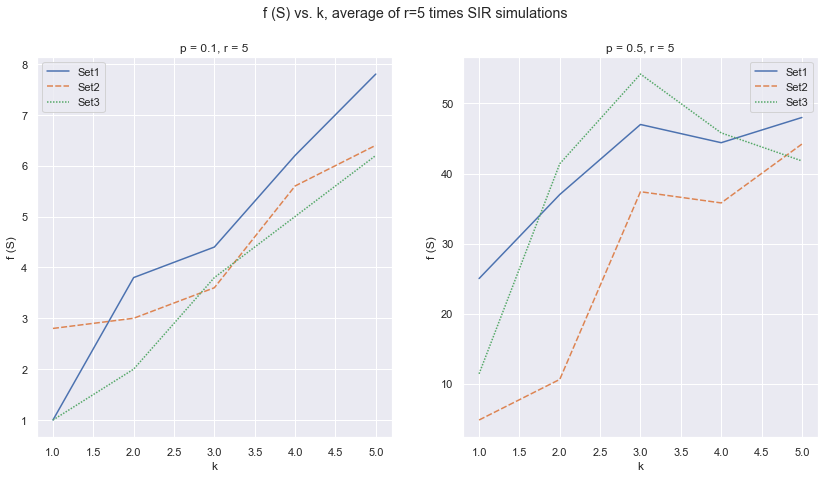

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax1 = sns.lineplot(ax=ax1,data=df_p1_r5)
ax2 = sns.lineplot(ax=ax2,data=df_p2_r5)
ax1.set(xlabel='k', ylabel='f (S)', title = 'p = 0.1, r = 5')
ax2.set(xlabel='k', ylabel='f (S)', title = 'p = 0.5, r = 5')
plt.suptitle('f (S) vs. k, average of r=5 times SIR simulations')
plt.show()
fig.savefig('r=5.png')

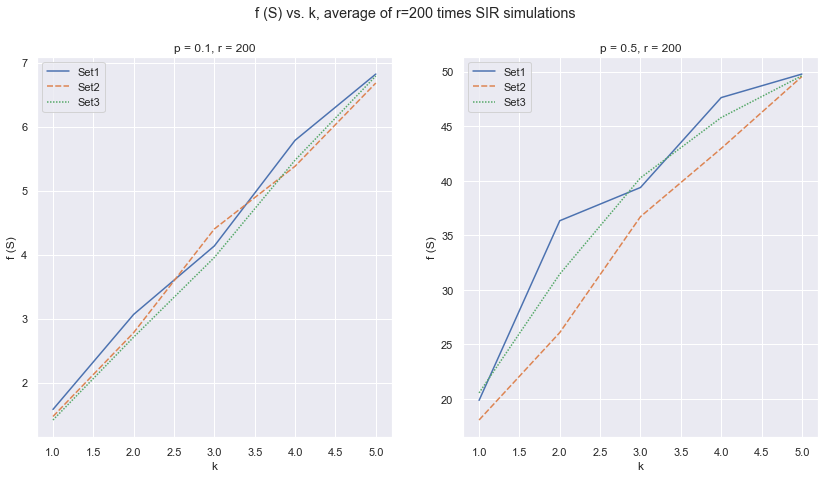

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax1 = sns.lineplot(ax=ax1,data=df_p1_r200)
ax2 = sns.lineplot(ax=ax2,data=df_p2_r200)
ax1.set(xlabel='k', ylabel='f (S)', title = 'p = 0.1, r = 200')
ax2.set(xlabel='k', ylabel='f (S)', title = 'p = 0.5, r = 200')
plt.suptitle('f (S) vs. k, average of r=200 times SIR simulations')
plt.show()
fig.savefig('r=200.png')

# Time compare

In [11]:
# Test set
test_set = random.sample(G.nodes(),7)

### One trial of r = 5 SIR simulation

In [12]:
%%time

greedy_find_k(G, 0.1,test_set,r=5)

Wall time: 4.99 ms


{1: 1.6, 2: 2.0, 3: 5.0, 4: 4.8, 5: 6.2}

### One trial of r = 200 SIR simulation

In [13]:
%%time

greedy_find_k(G, 0.1,test_set,r=200)

Wall time: 174 ms


{1: 1.335, 2: 2.76, 3: 4.005, 4: 5.34, 5: 6.515}